In [1]:
import chess
import chess.engine
import random
import numpy as np
import math
import tensorflow as tf
from keras import layers
import pandas as pd
from keras import models
from keras import optimizers
from keras import callbacks
import re

In [11]:
# Load our data
chess_data = pd.read_csv("./Data/chess_data.csv")
# Sample our data
chess_data = chess_data.sample(3000000)

# # Create a smaller csv for testing and stuff
chess_data.to_csv("./Data/sample_chess_data_3m.csv")

print(len(chess_data))

3000000


In [5]:
# Grab our sample data
chess_data = pd.read_csv("./Data/sample_chess_data.csv")

In [7]:
x_chess_data = []
y_chess_data = []

# First we create our empty matrix
# Second we map over every single possible piece
# Then we map over each square and see if that piece is on the square
def chess_matrix(chess_board):
    matrix = np.zeros((12, 8, 8), dtype=np.int8)

    for piece in chess.PIECE_TYPES:
        for square in chess_board.pieces(piece, chess.WHITE):
            # Piece type will correspond to what of the 12 matrixs we're posting to
            # Piece square will correspond to the inner matrix square we're posting to
            matrix[piece - 1][math.floor(square / 8)][square % 8] = 1
        for square in chess_board.pieces(piece, chess.BLACK):
            # We add 5 to pieces because black comes after white in the matrix
            matrix[piece + 5][math.floor(square / 8)][square % 8] = 1

    return matrix


# Our data will be x = board, y = evaluation
# Map over every item in the csv
# Create a board using the FEN
# Add it to the matrix using chess_matrix function
for index, row in chess_data.iterrows():
    # This is to get our x
    board = chess.Board(row["FEN"])
    matrix = chess_matrix(board)
    x_chess_data.append(matrix)
    # To get our y
    evaluation = row["Evaluation"]
    isCheckmate = evaluation.find("#")

    # We're going to use regex to remove invalid evaluation forms
    regex = r'[^a-zA-Z_@$&*{}[],=\( \).;\'/]'
    evaluation = re.sub(regex, '', evaluation)

    if (isCheckmate != -1):
        evaluation = evaluation.replace("#", "")
        evaluation = int(evaluation)

        # I can't be bothered with adding checkmate functionality, so if it's near checkmate, modify it by 3000
        # Check if evaluation is positive or negative
        if evaluation > 0:
            # If positive, add positive 3000
            evaluation += 3000
        elif evaluation < 0:
            # If negative, add negative 3000
            evaluation -= 3000

    evaluation = int(evaluation)

    y_chess_data.append(evaluation)


# Turn all of the arrays into numpy arrays
x_chess_data = np.array(x_chess_data)
y_chess_data = np.array(y_chess_data)

# Turn the numpy arrays into float 64
x_chess_data = x_chess_data.astype(np.float32)
y_chess_data = y_chess_data.astype(np.float32)

np.save('Data/x_chess_data.npy', x_chess_data)
np.save('Data/y_chess_data.npy', y_chess_data)

+168
+103
-75
+323
-729
+175
+48
-85
+23
-225
+583
-716
-662
+406
-850
+176
-356
+27
-397
-13
+275
+61
+32
+488
-7
0
0
+20
+10
0
+112
0
+33
-237
-220
0
+108
-252
+83
0
+789
-92
+287
+93
+156
+197
-238
-412
+49
+541
+184
+980
+541
+746
+115
+1565
+164
+544
-427
+123
0
+69
-92
+271
-61
-16
+152
-91
-261
+716
+107
+482
+190
+145
+45
+44
+114
+1191
+568
+537
+27
+168
-554
+83
+155
+17
+133
-33
+15
+81
+453
+154
-109
-130
+339
+24
0
+55
-756
0
+851
+62
-107
0
+21
+302
+319
0
+116
+215
+259
-15
+573
-186
+289
-101
+35
0
-57
-583
0
+33
-519
-24
+760
+95
-74
+491
-248
+52
-672
+50
-173
+198
-11
-849
+492
-47
+169
-232
+296
+13
0
+120
+107
-96
+155
+36
-286
+129
-44
0
0
+41
+328
+6133
+397
0
+124
+414
-140
+13
+76
0
-88
-127
0
+721
+90
#+9
+200
+36
-73
-3
+147
-329
0
+47
-630
-16
+17
-127
+950
+10
+672
0
-3
+160
+136
-54
+61
0
-7
+207
+573
-201
-51
+2338
-313
+1089
-27
+637
+158
-103
+167
-1354
-405
+105
-5
-23
+56
-200
+161
-93
+95
-115
+384
+113
0
-76
-181
+6147
-494
+121
+216
-80
-57
0
-13
-

In [8]:
x_chess_data = np.load("Data/x_chess_data.npy")
y_chess_data = np.load("Data/y_chess_data.npy")

In [9]:
activation_mode="relu"

def build_model_residual(conv_size, conv_depth):
  board3d = layers.Input(shape=(12, 8, 8))

  # adding the convolutional layers
  x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same')(board3d)
  for _ in range(conv_depth):
    previous = x
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, previous])
    x = layers.Activation('relu')(x)
  x = layers.Flatten()(x)
  x = layers.Dense(1, 'sigmoid')(x)

  return models.Model(inputs=board3d, outputs=x)

model = build_model_residual(32, 4)

In [10]:
epochs=10
batch_size=2048
verbose=1
validation_split=0.1

model.compile(optimizer=optimizers.Adam(5e-4), loss='mean_absolute_error')

model.fit(
    x_chess_data, 
    y_chess_data,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
    validation_split=validation_split,
    callbacks=[callbacks.ReduceLROnPlateau(monitor='loss', patience=10)]
)

Epoch 1/10
110/110 [==============================] - 141s 1s/step - loss: 343.5997 - val_loss: 348.1770 - lr: 5.0000e-04
Epoch 2/10
110/110 [==============================] - 137s 1s/step - loss: 343.5518 - val_loss: 348.1478 - lr: 5.0000e-04
Epoch 3/10
  4/110 [>.............................] - ETA: 2:06 - loss: 349.1846

KeyboardInterrupt: 

In [22]:
model.save('chess_model.h5')

C:\Users\keira\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
model = models.load_model('chess_model.h5')

In [10]:
# this function will create our x (board)
def random_board(max_depth=200):
  board = chess.Board()
  depth = random.randrange(0, max_depth)

  for _ in range(depth):
    all_moves = list(board.legal_moves)
    random_move = random.choice(all_moves)
    board.push(random_move)
    if board.is_game_over():
      break

  return board


# this function will create our f(x) (score)
def stockfish(board, depth):
  with chess.engine.SimpleEngine.popen_uci("stockfish.exe") as sf:
    result = sf.analyse(board, chess.engine.Limit(depth=depth))
    score = result['score'].white().score()
    return score

R . . . R . . .
. . . . . . . .
. . . . . k . .
. p n . N . . .
. . . . p . . .
P . . p n . . .
K . . . . . . .
. r . . . . . .
-622


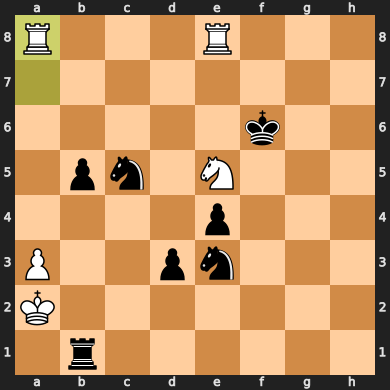

In [11]:
board = random_board()
print(board)
print(stockfish(board, 22))
board

In [12]:
# used for the minimax algorithm
def minimax_eval(board):
  board3d = chess_matrix(board)
  board3d = np.expand_dims(board3d, 0)
  return model(board3d)[0][0]


def minimax(board, depth, alpha, beta, maximizing_player):
  if depth == 0 or board.is_game_over():
    return minimax_eval(board)
  
  if maximizing_player:
    max_eval = -np.inf
    for move in board.legal_moves:
      board.push(move)
      eval = minimax(board, depth - 1, alpha, beta, False)
      board.pop()
      max_eval = max(max_eval, eval)
      alpha = max(alpha, eval)
      if beta <= alpha:
        break
    return max_eval
  else:
    min_eval = np.inf
    for move in board.legal_moves:
      board.push(move)
      eval = minimax(board, depth - 1, alpha, beta, True)
      board.pop()
      min_eval = min(min_eval, eval)
      beta = min(beta, eval)
      if beta <= alpha:
        break
    return min_eval


# this is the actual function that gets the move from the neural network
def get_ai_move(board, depth):
  print("RUNNING GET AI MOVE")
  max_move = None
  max_eval = -np.inf

  for move in board.legal_moves:
    print("CURRENT MOVE: ", move)
    board.push(move)
    eval = minimax(board, depth - 1, -np.inf, np.inf, False)
    print(eval, move)
    board.pop()
    if eval > max_eval:
      max_eval = eval
      max_move = move
  
  return max_move

In [41]:
best_move = get_ai_move(board, 3)

RUNNING GET AI MOVE
CURRENT MOVE:  e8f8
tf.Tensor(0.7263911, shape=(), dtype=float32) e8f8
CURRENT MOVE:  e8d8
tf.Tensor(0.7234303, shape=(), dtype=float32) e8d8
CURRENT MOVE:  e8f7
tf.Tensor(0.72552097, shape=(), dtype=float32) e8f7
CURRENT MOVE:  e8e7
tf.Tensor(0.7305128, shape=(), dtype=float32) e8e7
CURRENT MOVE:  e8d7
tf.Tensor(0.72970706, shape=(), dtype=float32) e8d7
CURRENT MOVE:  d2e4
tf.Tensor(0.7168684, shape=(), dtype=float32) d2e4
CURRENT MOVE:  d2c4
tf.Tensor(0.7272246, shape=(), dtype=float32) d2c4
CURRENT MOVE:  d2f3
tf.Tensor(0.7229895, shape=(), dtype=float32) d2f3
CURRENT MOVE:  d2f1
tf.Tensor(0.7229895, shape=(), dtype=float32) d2f1
CURRENT MOVE:  d2b1
tf.Tensor(0.71950394, shape=(), dtype=float32) d2b1
CURRENT MOVE:  d1h1
tf.Tensor(0.7213055, shape=(), dtype=float32) d1h1
CURRENT MOVE:  d1g1
tf.Tensor(0.7095123, shape=(), dtype=float32) d1g1
CURRENT MOVE:  d1f1
tf.Tensor(0.7221499, shape=(), dtype=float32) d1f1
CURRENT MOVE:  d1e1
tf.Tensor(0.7095123, shape=(), dty

In [23]:
print(minimax_eval(board))

tf.Tensor(0.65711015, shape=(), dtype=float32)


In [42]:
print(best_move)
print(board.fen)

f2f4
<bound method Board.fen of Board('4K3/7k/2P1p2p/5p1p/3P2b1/1P6/3NPP2/2BR4 w - - 22 85')>
